<div style="text-align: center;">
    <a href="https://www.ip-paris.fr/en/education/masters/applied-mathematics-and-statistics-program/master-year-2-data-science">
        <img border="0" src="https://www.ip-paris.fr/sites/default/files/presse/Charte%20Graphique/2025/LOGOTYPE-7-ECOLES-Vertical.png" width="90%"></a>
</div>

# RAMP on Satellites decay date prediction

<i> Erwan CELANIE, Jaishan BURTON ELMO, Kevin ALINEJAD, Nizar ZEROUALE, Jad AOUAD, Othmane LKHALIDI</i>

## Introduction  

### The disintegration of satellites  

Artificial satellites placed in orbit around the Earth do not remain operational indefinitely. Over time, Earth's gravitational pull, atmospheric drag, and other factors influence their trajectory, eventually leading to their disintegration (or decay). Accurately predicting the decay date of satellites is a crucial challenge for managing space traffic and ensuring the safety of orbital infrastructures.  

### The Space Track database  

The data used for this challenge comes from the <a href="https://www.space-track.org//basicspacedata/query/class/gp/decay_date/<>null-val/orderby/NORAD_CAT_ID/format/html">**Space-Track** platform</a>, which centralizes information on orbiting objects, including active satellites, space debris, and decommissioned spacecraft. These data are collected by the **United States Space Surveillance Network (SSN)** and made available for analysis and orbital forecasting.  

# Exploratory data analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
pd.set_option('display.max_columns', None)

## Get access to the training data

In [2]:
import problem

X_df, y = problem.get_train_data()
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16886 entries, 1 to 25009
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CCSDS_OMM_VERS       16886 non-null  float64       
 1   COMMENT              16886 non-null  object        
 2   CREATION_DATE        16886 non-null  object        
 3   ORIGINATOR           16886 non-null  object        
 4   OBJECT_NAME          16886 non-null  object        
 5   OBJECT_ID            16886 non-null  object        
 6   CENTER_NAME          16886 non-null  object        
 7   REF_FRAME            16886 non-null  object        
 8   TIME_SYSTEM          16886 non-null  object        
 9   MEAN_ELEMENT_THEORY  16886 non-null  object        
 10  EPOCH                16886 non-null  object        
 11  MEAN_MOTION          16886 non-null  float64       
 12  ECCENTRICITY         16886 non-null  float64       
 13  INCLINATION          16886 non-null 

## The features

<span style="color:red">Red variables</span> are identifiers, labels, or other human-annotated features, so they should not be used as input in the prediction model.
<span style="color:lightblue">Light blue variables</span> are legal but not likely to contribute significant information to the prediction.
Black variables are definitely discriminative.

<ul> <li> <code><b><span style="color:red">CCSDS_OMM_VERS</span></b></code>: Version of the CCSDS Orbit Mean-Elements Message (OMM) format. <li> <code><b><span style="color:red">COMMENT</span></b></code>: General information about the satellite data source. <li> <code><b><span style="color:red">CREATION_DATE</span></b></code>: Date when this dataset was created. <li> <code><b><span style="color:red">ORIGINATOR</span></b></code>: Organization responsible for the data (e.g., 18 SPCS). </ul>
Satellite Metadata
<ul> <li> <code><b><span style="color:red">OBJECT_ID</span></b></code>: Unique identifier for the satellite. <li> <code><b><span style="color:red">OBJECT_NAME</span></b></code>: Name of the satellite. <li> <code><b><span style="color:red">NORAD_CAT_ID</span></b></code>: NORAD catalog identifier assigned to the satellite. <li> <code><b>COUNTRY_CODE</b></code>: Country of origin of the satellite. <li> <code><b>OBJECT_TYPE</b></code>: Type of object (e.g., PAYLOAD, DEBRIS). </ul>
Orbital Elements
<ul> <li> <code><b><span style="color:black">EPOCH</span></b></code>: Epoch time for the provided orbital elements. <li> <code><b><span style="color:black">MEAN_MOTION</span></b></code>: Number of revolutions per day (rev/day). <li> <code><b><span style="color:black">ECCENTRICITY</span></b></code>: Measure of the orbit's deviation from a perfect circle. <li> <code><b><span style="color:black">INCLINATION</span></b></code>: Orbital inclination angle (in degrees). <li> <code><b><span style="color:black">RA_OF_ASC_NODE</span></b></code>: Right Ascension of the Ascending Node (in degrees). <li> <code><b><span style="color:black">ARG_OF_PERICENTER</span></b></code>: Argument of perigee/pericenter (in degrees). <li> <code><b><span style="color:black">MEAN_ANOMALY</span></b></code>: Mean anomaly at the epoch (in degrees). </ul>
Tracking and Atmospheric Drag Parameters
<ul> <li> <code><b><span style="color:red">ELEMENT_SET_NO</span></b></code>: Version number of the orbital element set. <li> <code><b><span style="color:black">REV_AT_EPOCH</span></b></code>: Number of revolutions completed since launch at the epoch time. <li> <code><b><span style="color:black">BSTAR</span></b></code>: Drag coefficient affecting atmospheric resistance. <li> <code><b><span style="color:black">MEAN_MOTION_DOT</span></b></code>: First derivative of mean motion (rad/s²), indicating acceleration due to drag. <li> <code><b><span style="color:black">MEAN_MOTION_DDOT</span></b></code>: Second derivative of mean motion (rad/s³), usually close to zero. </ul>
Orbital Characteristics
<ul> <li> <code><b><span style="color:black">SEMIMAJOR_AXIS</span></b></code>: Semi-major axis of the orbit (in km). <li> <code><b><span style="color:black">PERIOD</span></b></code>: Orbital period of the satellite (in minutes). <li> <code><b><span style="color:black">APOAPSIS</span></b></code>: Maximum altitude reached by the satellite (in km). <li> <code><b><span style="color:black">PERIAPSIS</span></b></code>: Minimum altitude reached by the satellite (in km). </ul>
Satellite Type and Physical Attributes
<ul> <li> <code><b><span style="color:lightblue">RCS_SIZE</span></b></code>: Estimated radar cross-section category (SMALL, MEDIUM, LARGE). <li> <code><b><span style="color:red">RCS_VALUE</span></b></code>: Numerical radar cross-section value. (EMPTY)</ul>
Launch and Decay Information
<ul> <li> <code><b><span style="color:red">LAUNCH_DATE</span></b></code>: Date when the satellite was launched. <li> <code><b><span style="color:red">DECAY_DATE</span></b></code>: Date of satellite disintegration (target, label to predict). </ul>
Additional Tracking Data
<ul> <li> <code><b><span style="color:red">FILE</span></b></code>: Internal file reference ID. <li> <code><b><span style="color:red">GP_ID</span></b></code>: General Perturbation ID. <li> <code><b><span style="color:lightblue">TLE_LINE0</span></b></code>: First line of the Two-Line Element Set (TLE) for tracking. <li> <code><b><span style="color:lightblue">TLE_LINE1</span></b></code>: Second line of the TLE containing orbital elements. <li> <code><b><span style="color:lightblue">TLE_LINE2</span></b></code>: Third line of the TLE containing additional tracking data. </ul>

In [3]:
X_df.head()

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
1,3.0,GENERATED VIA SPACE-TRACK.ORG API,2023-10-07T17:28:49,18 SPCS,NUSAT-11 CORA,2020-079C,EARTH,TEME,UTC,SGP4,2023-10-07T02:47:45.242304,16.479814,0.001069,97.1006,355.5139,266.1137,93.8945,0,U,46829,999,16421,0.000215,0.140084,0.000002,6522.793,87.380,151.633,137.684,PAYLOAD,MEDIUM,ARGN,2020-11-06,TSC,4027321,238643749,0 NUSAT-11 CORA,1 46829U 20079C 23280.11649586 .14008429 2...,2 46829 97.1006 355.5139 0010693 266.1137 93...
2,3.0,GENERATED VIA SPACE-TRACK.ORG API,2023-05-24T06:26:12,18 SPCS,DMSP 5D-2 F15 DEB,1999-067D,EARTH,TEME,UTC,SGP4,2023-05-23T18:33:11.428416,15.790044,0.002217,98.7839,86.7317,160.2595,199.9530,0,U,26146,999,23674,0.012126,0.025150,0.000000,6711.397,91.197,348.143,318.382,DEBRIS,MEDIUM,US,1999-12-12,AFWTR,3915786,232409087,0 DMSP 5D-2 F15 DEB,1 26146U 99067D 23143.77304894 .02514981 0...,2 26146 98.7839 86.7317 0022172 160.2595 199...
3,3.0,GENERATED VIA SPACE-TRACK.ORG API,2024-10-02T19:24:27,18 SPCS,MICRODRAGON,2019-003D,EARTH,TEME,UTC,SGP4,2024-10-01T06:19:57.433152,16.514244,0.000937,97.0439,293.7887,285.9496,74.0778,0,U,43935,999,31867,0.000148,0.161708,0.000002,6513.724,87.197,141.690,129.489,PAYLOAD,MEDIUM,JPN,2019-01-18,KSCUT,4512136,269511738,0 MICRODRAGON,1 43935U 19003D 24275.26385918 .16170828 2...,2 43935 97.0439 293.7887 0009366 285.9496 74...
4,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-02-15T07:46:15,18 SPCS,STARLINK-2000,2021-009AZ,EARTH,TEME,UTC,SGP4,2025-02-15T05:56:26.077920,16.438352,0.000548,53.0195,299.3636,224.8203,229.5282,0,U,47595,999,22329,0.000518,0.136493,0.000012,6533.757,87.600,159.205,152.040,PAYLOAD,LARGE,US,2021-02-04,AFETR,4641356,280776657,0 STARLINK-2000,1 47595U 21009AZ 25046.24752405 .13649268 1...,2 47595 53.0195 299.3636 0005483 224.8203 229...
5,3.0,GENERATED VIA SPACE-TRACK.ORG API,2008-07-23T23:55:14,18 SPCS,CZ-4 DEB,1999-057HP,EARTH,TEME,UTC,SGP4,2008-07-23T23:02:09.292992,16.247275,0.001399,98.6053,359.2413,279.9671,90.7511,0,U,26330,999,45954,0.001344,0.037679,0.000003,6584.888,88.630,215.967,197.539,DEBRIS,SMALL,PRC,1999-10-14,TSC,583048,67229755,0 CZ-4 DEB,1 26330U 99057HP 08205.95982978 .03767852 3...,2 26330 098.6053 359.2413 0013992 279.9671 090...


## Data exploration

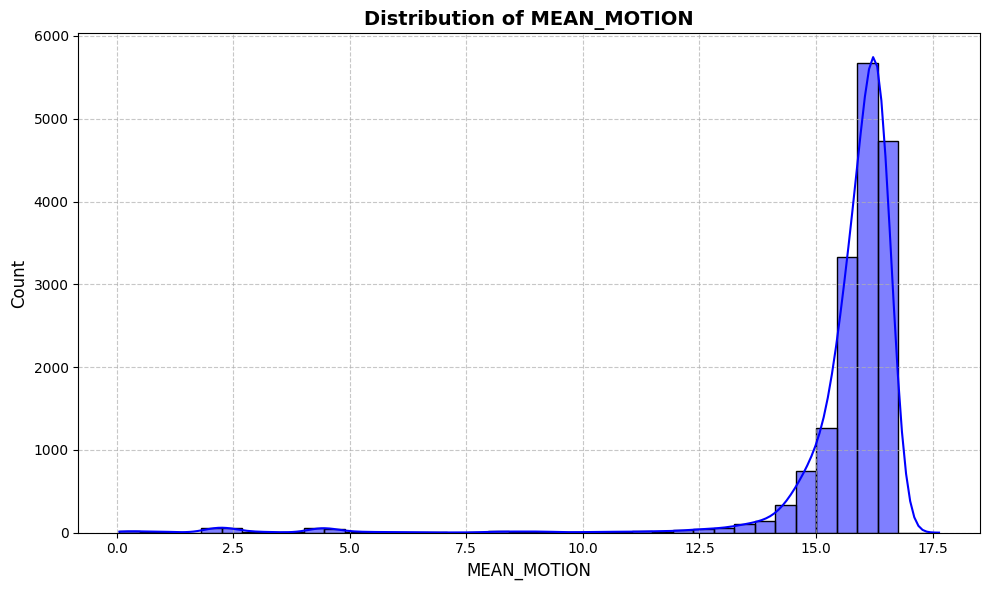

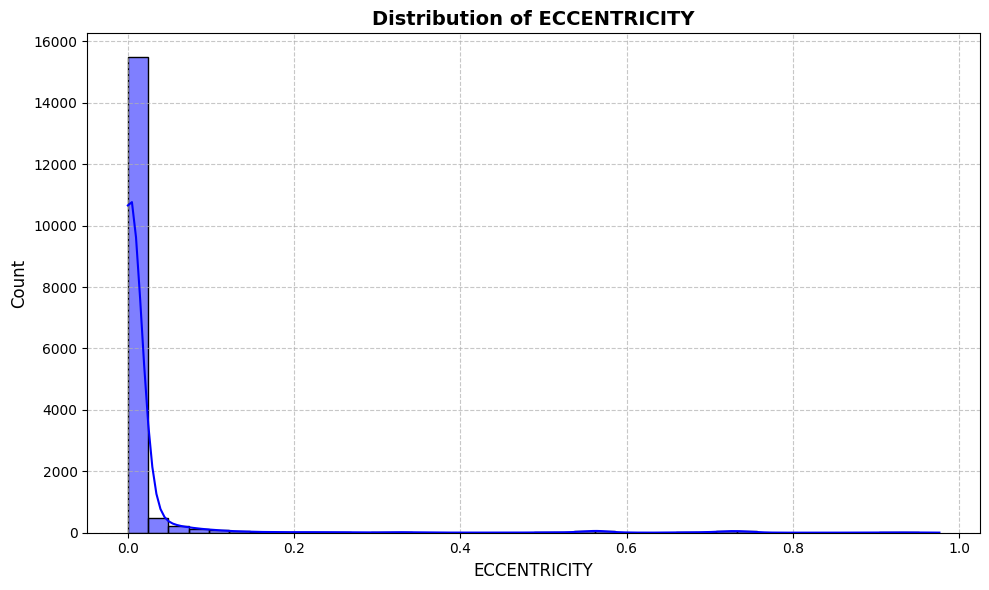

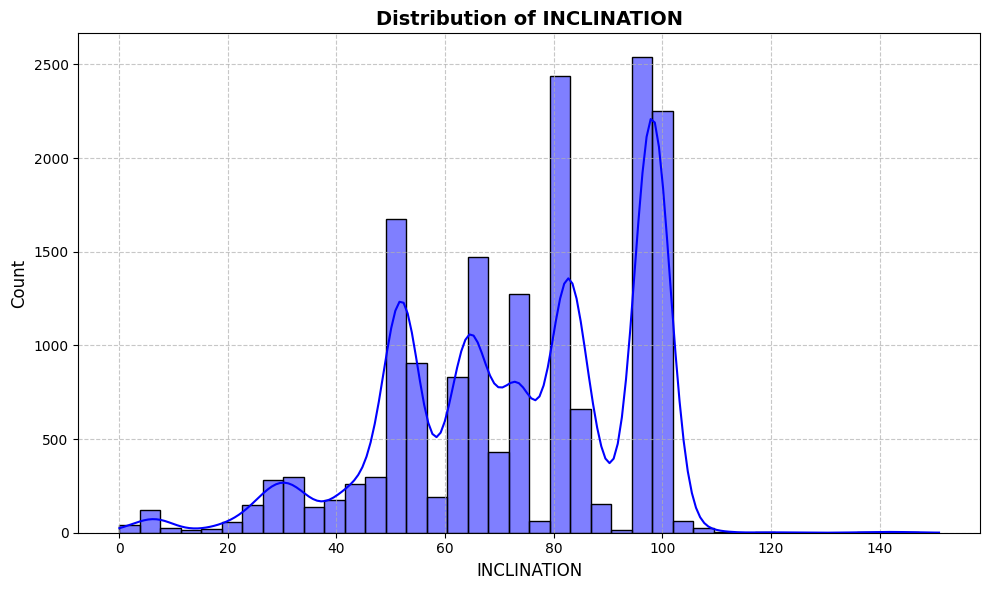

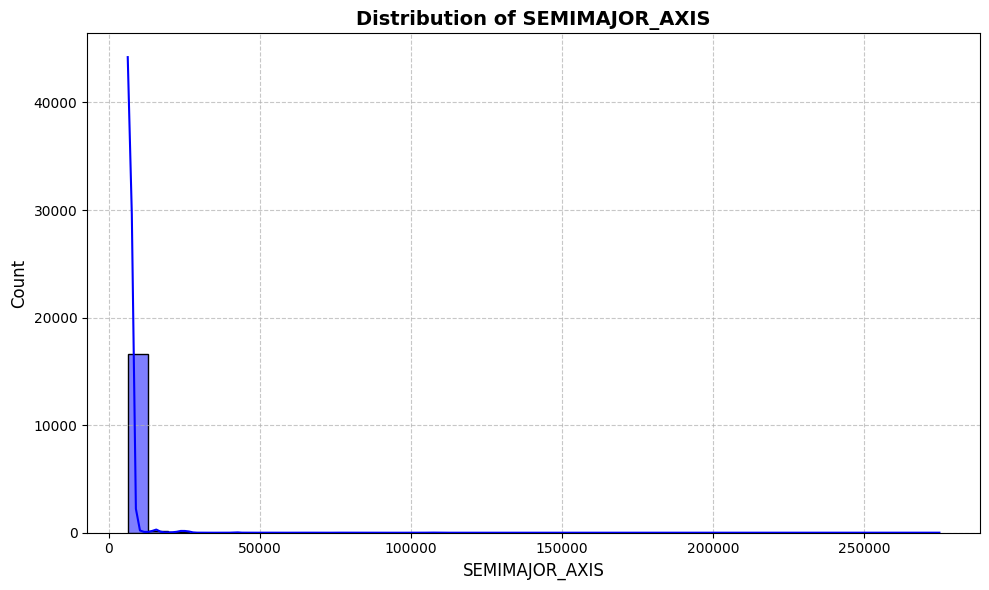

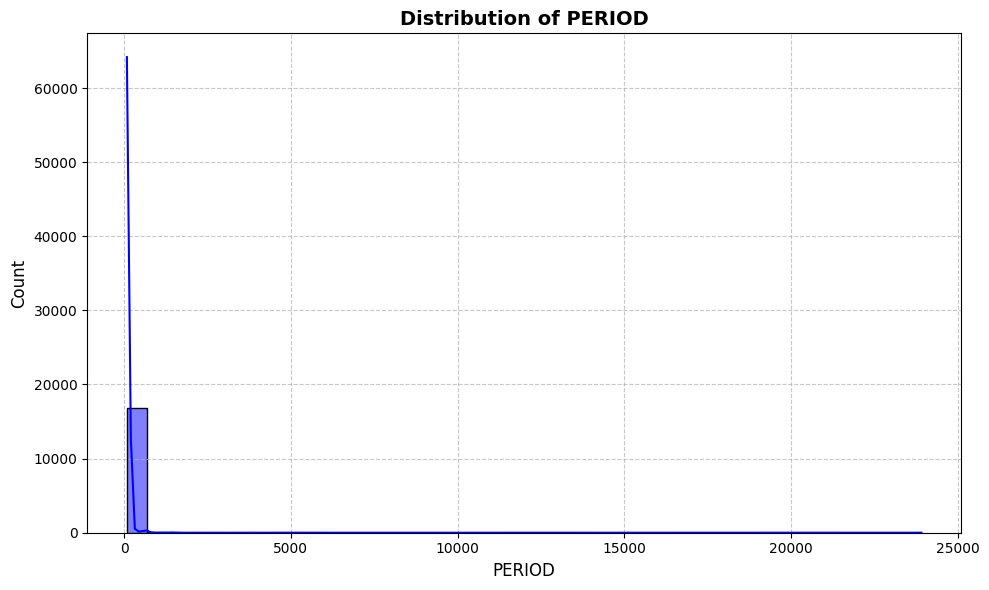

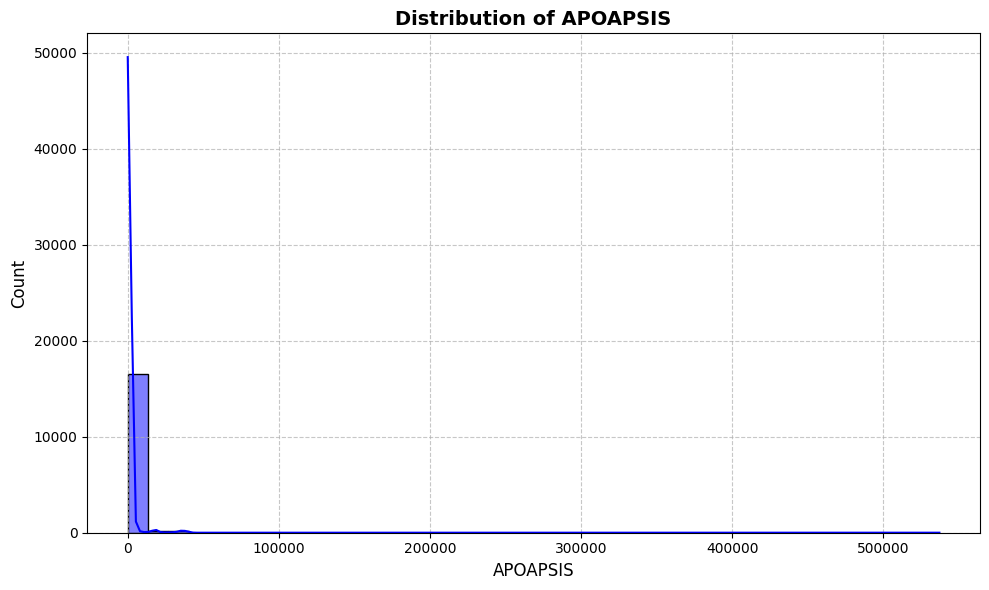

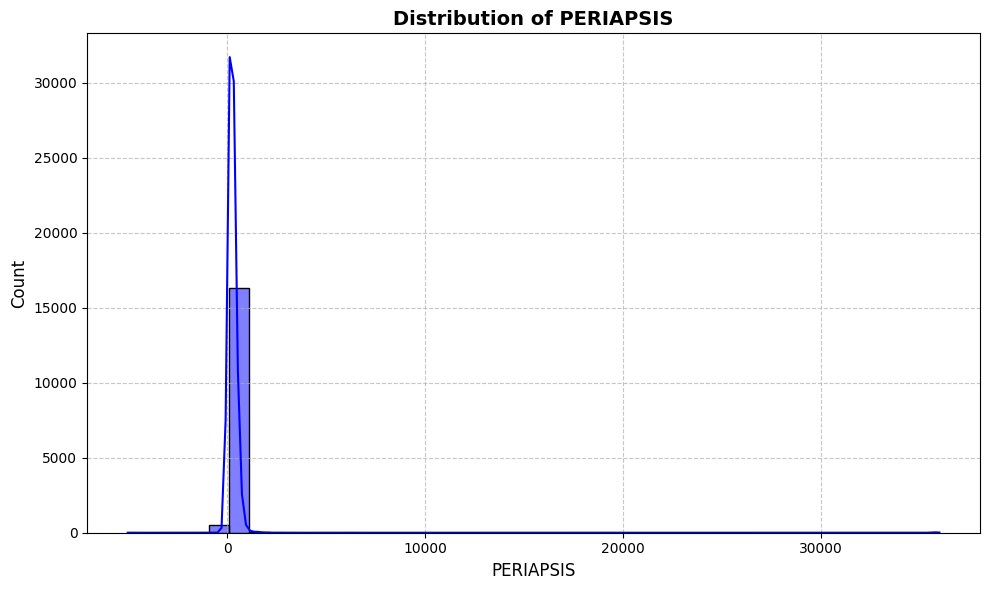

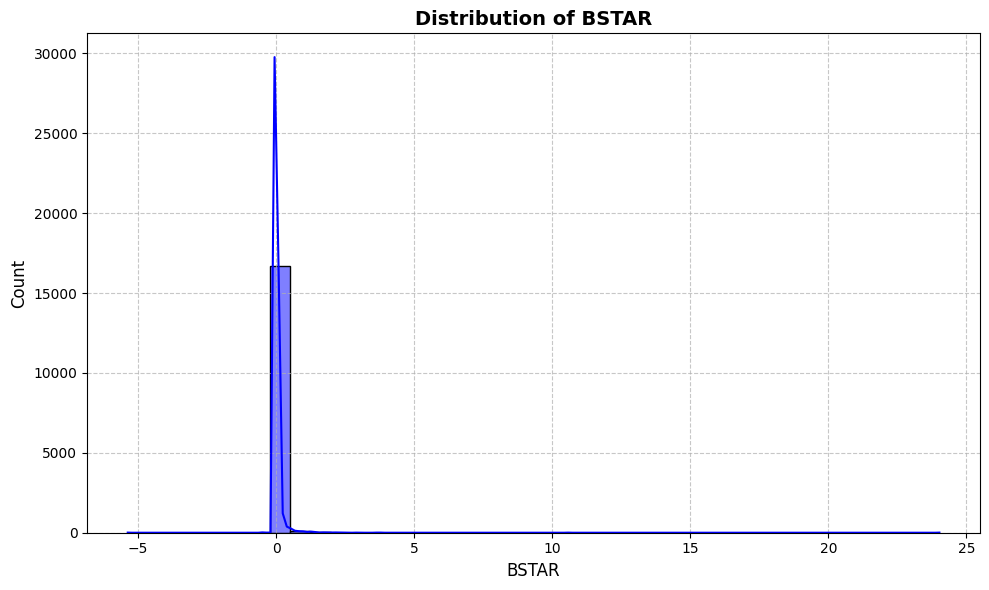

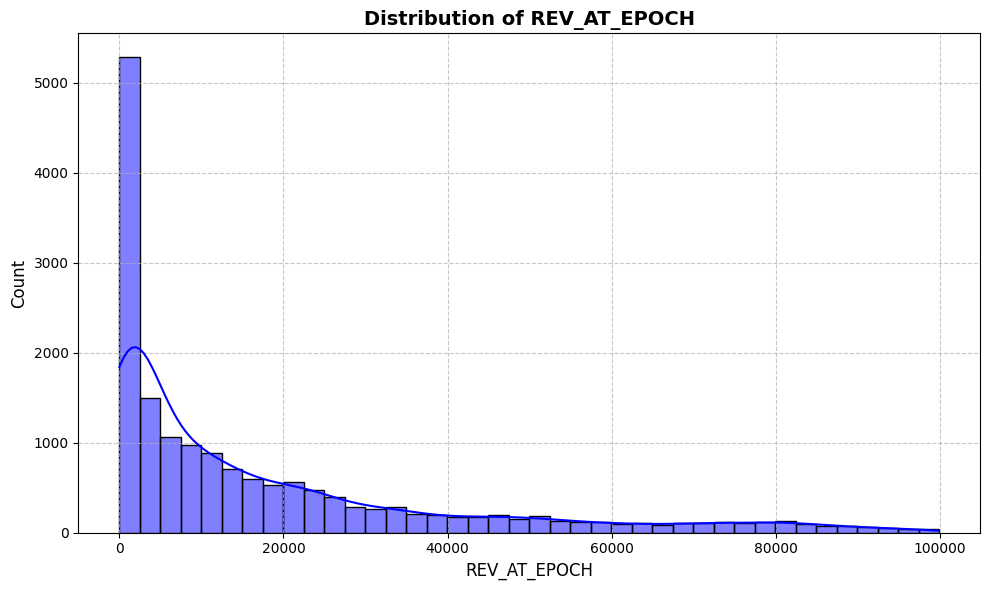

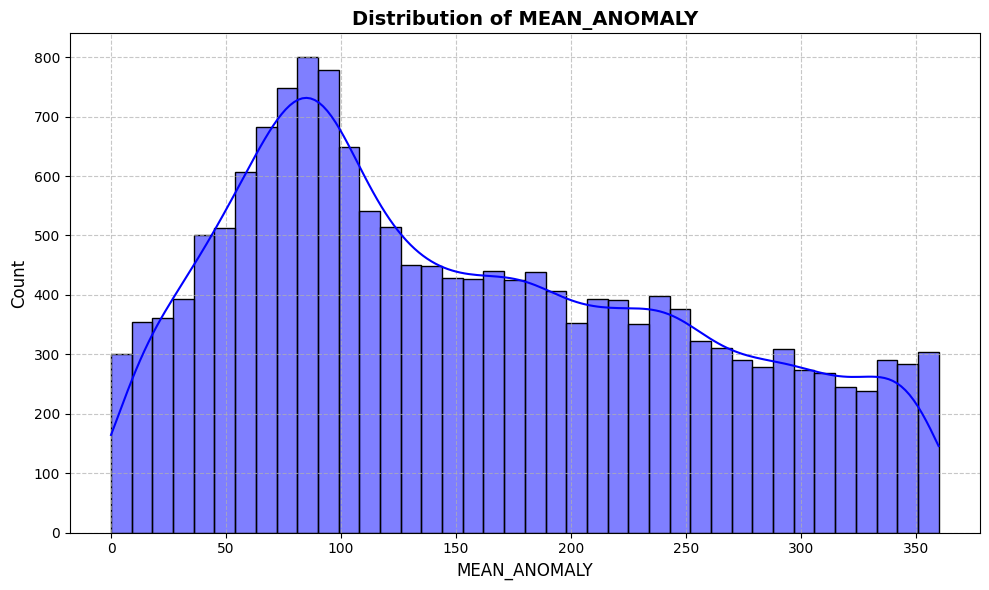

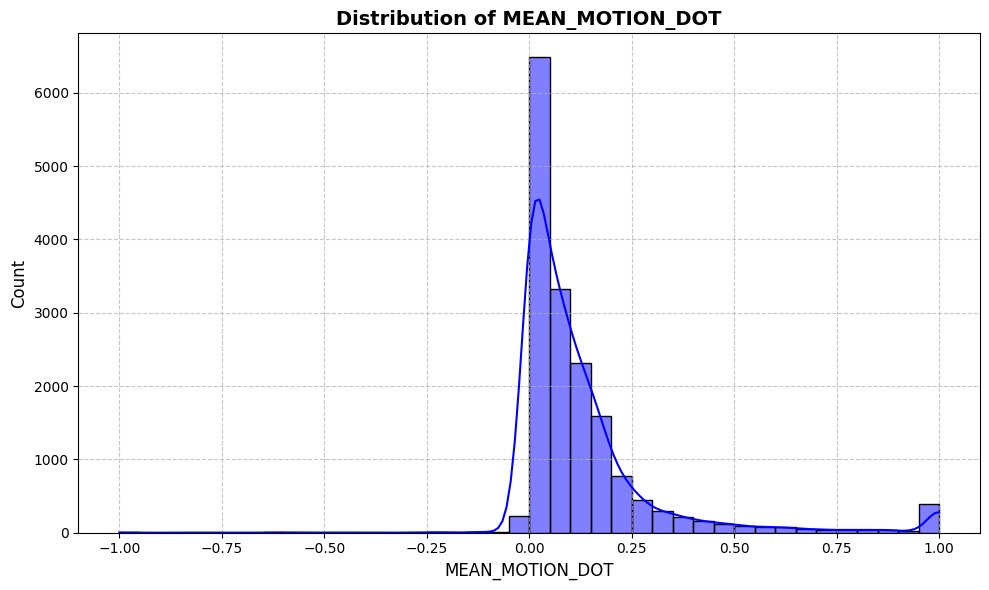

In [4]:
def plot_histograms(df, columns, bins=30, figsize=(10, 6), color="dodgerblue"):
    """
    Plot histograms for numerical variables.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    columns (list): List of numerical columns to plot.
    bins (int): Number of bins in the histogram.
    figsize (tuple): Size of the figure.
    color (str): Color of the bars.
    """
    for col in columns:
        plt.figure(figsize=figsize)

        sns.histplot(df[col], bins=bins, kde=True, color=color)  
        plt.title(f'Distribution of {col}', fontsize=14, fontweight='bold')
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

numerical_vars = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'SEMIMAJOR_AXIS',
                  'PERIOD', 'APOAPSIS', 'PERIAPSIS', 'BSTAR', 'REV_AT_EPOCH', 'MEAN_ANOMALY', 'MEAN_MOTION_DOT']

plot_histograms(X_df, numerical_vars, bins=40, color="blue")  

C:\Users\jaish\AppData\Local\Temp\ipykernel_3808\4174829410.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


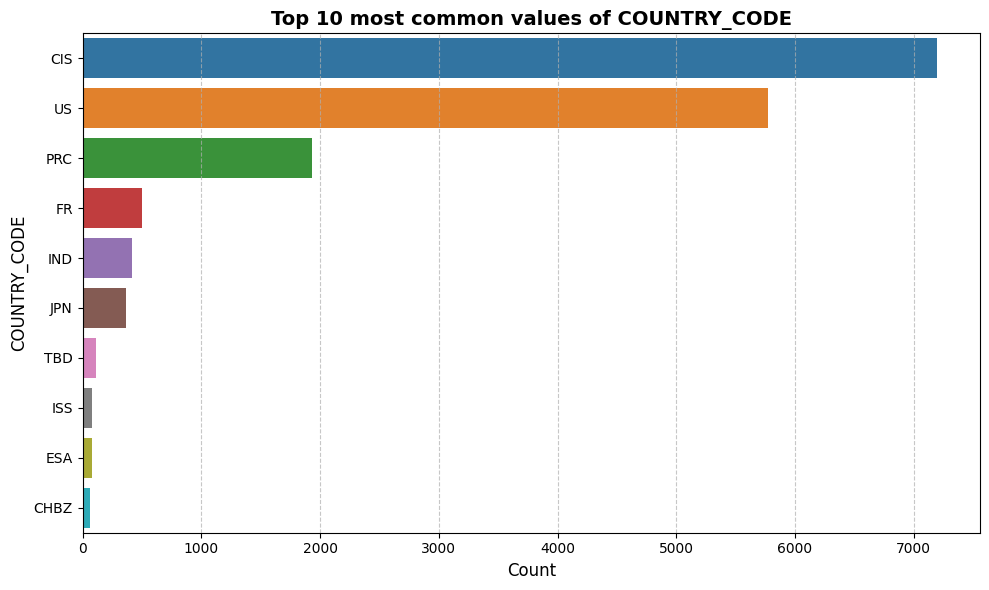

C:\Users\jaish\AppData\Local\Temp\ipykernel_3808\4174829410.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


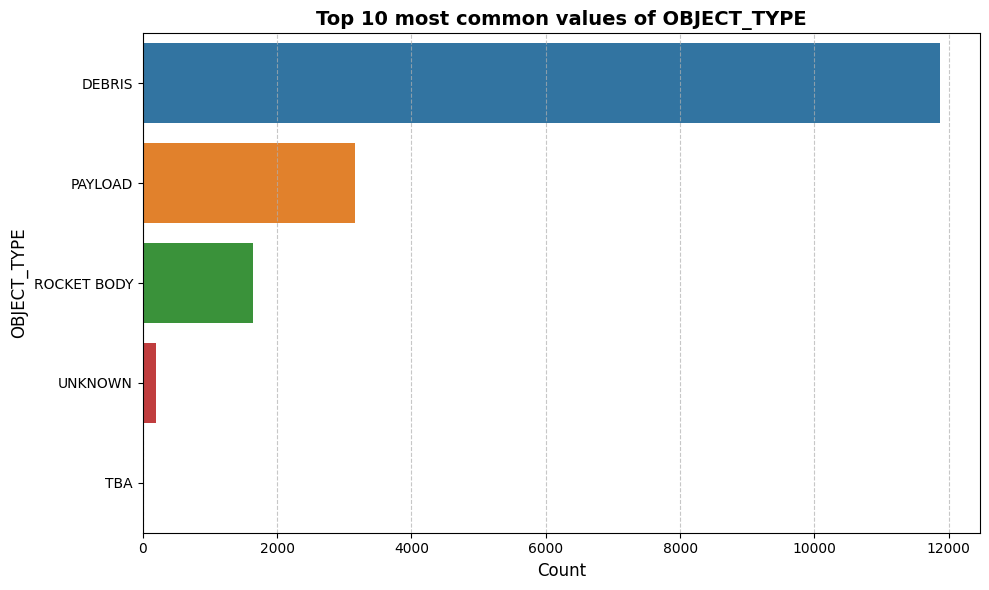

C:\Users\jaish\AppData\Local\Temp\ipykernel_3808\4174829410.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


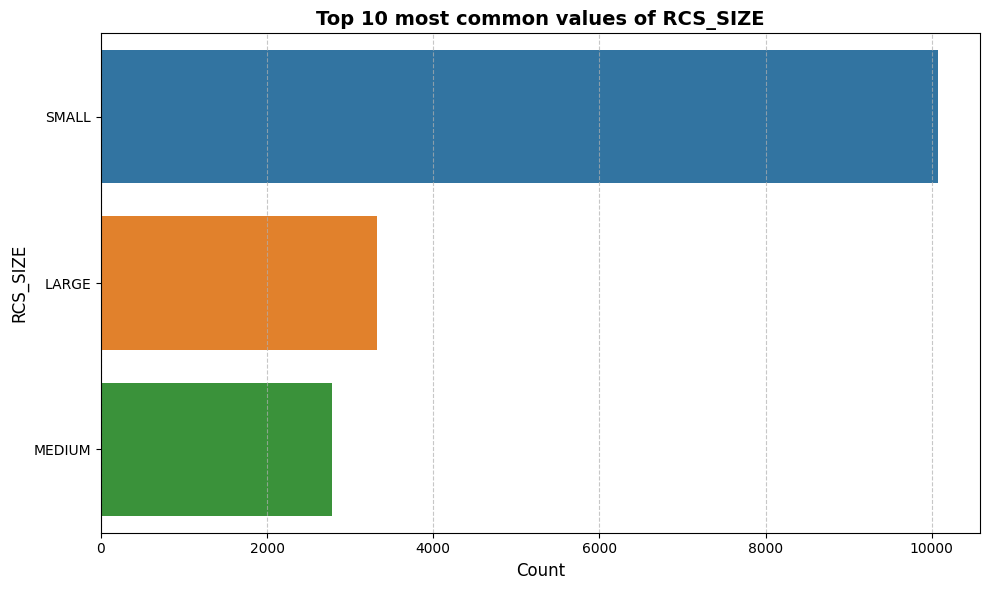

In [5]:
def plot_top_barplots(df, columns, top_n=10, figsize=(10, 6), palette="coolwarm"):
    """
    Plot bar plots for categorical variables, showing only the top N most frequent categories, with colors.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    columns (list): List of categorical columns to plot.
    top_n (int): Number of most frequent categories to display.
    figsize (tuple): Size of the figure.
    palette (str): Color palette for the bars.
    """
    for col in columns:
        plt.figure(figsize=figsize)

        top_values = df[col].value_counts().nlargest(top_n)

        sns.barplot(
            y=top_values.index, 
            x=top_values.values, 
            palette=sns.color_palette(palette, len(top_values)), 
            orient='h'
        )

        plt.title(f'Top {top_n} most common values of {col}', fontsize=14, fontweight='bold')
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)  
        plt.tight_layout()
        plt.show()

categorical_vars = ['COUNTRY_CODE', 'OBJECT_TYPE', 'RCS_SIZE']
plot_top_barplots(X_df, categorical_vars, top_n=10, palette="tab10") 


## Submission

The goal of this RAMP challenge is to design an algorithm that accurately predicts the decay date of satellites using their orbital parameters.

Combined with some static features and plugged into a random forest it reads;

In [ ]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor


class RF_regressor(RandomForestRegressor):
    def fit(self, X, y):
        return super().fit(X, y)


cols = [
    "CCSDS_OMM_VERS", "MEAN_MOTION", "ECCENTRICITY", "INCLINATION", 
    "RA_OF_ASC_NODE", "ARG_OF_PERICENTER", "MEAN_ANOMALY", "EPHEMERIS_TYPE",
    "NORAD_CAT_ID", "ELEMENT_SET_NO", "REV_AT_EPOCH", "BSTAR", 
    "MEAN_MOTION_DOT", "MEAN_MOTION_DDOT", "SEMIMAJOR_AXIS", "PERIOD",
    "APOAPSIS", "PERIAPSIS", "GP_ID"
]


transformer = make_column_transformer(
    ('passthrough', cols)
)

pipe = make_pipeline(
    transformer,
    RF_regressor(n_estimators=10, random_state=42)
)


def get_estimator():
    return pipe

## Testing using a scikit-learn pipeline

In [7]:
import problem
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data()

scores = cross_val_score(get_estimator(), X_df, y, cv=2, scoring='neg_root_mean_squared_error')

print("Cross-validation RMSE scores:", -scores)
print("Mean RMSE:", -scores.mean())

Cross-validation RMSE scores: [1479.27372932 1503.35010357]
Mean RMSE: 1491.311916443959


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).